In [7]:
# Import Required Libraries
import pandas as pd
import numpy as np
import re
import os
import glob 
import json
import joblib
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# XGBoost
import xgboost as xgb

# Scipy stats for parameter distributions
from scipy.stats import uniform, randint

# Disable file validation warning
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Target Selection and Configuration

Choose the target variable for modeling from the options below.

In [8]:
# Target options for reference
TARGET_OPTIONS = {
    'GINI': 'SI.POV.GINI',      # Gini coefficient (measure of inequality)
    'top10': 'SI.DST.10TH.10',  # Top 10% wealth share
    'bottom10': 'SI.DST.FRST.10' # Bottom 10% wealth share
}

In [9]:
print('Date ranges available:')
for file in glob.glob('input/imputed/*.csv'):
    date_start = file.split('/')[-1].split('.')[0].split('_')[-3]
    date_end = file.split('/')[-1].split('.')[0].split('_')[-1]
    print(f"{date_start}_to_{date_end}")

Date ranges available:
2000_to_2020


In [10]:
selected_target = 'bottom10'
selected_date_range = '2000_to_2020'

# Configuration

Define all path variables here for easy modification

In [17]:
# Random seed for reproducibility
SEED = 20250406

# Target
TARGET = TARGET_OPTIONS[selected_target]

# Input paths
INPUT_DIR = 'input'
IMPUTED_DIR = f'{INPUT_DIR}/imputed'
TRANSFORMED_DIR = f'{INPUT_DIR}/transformed'
TRAIN_TEST_VAL_DIR = f'{INPUT_DIR}/train_test_val'
REFERENCE_DIR = 'output/reference'

# Data files
DATA_FILE = f'{IMPUTED_DIR}/df_wide_knn_imputed_{selected_date_range}.csv'
TARGET_FILE = f'{TRANSFORMED_DIR}/df_wide_targets_{selected_date_range}.csv'
INDICATOR_LOOKUP_FILE = f'{REFERENCE_DIR}/indicator_lookup.csv'

# Extract implied date range from data file name
DATE_RANGE = re.search(r'(\d+)_to_(\d+)', DATA_FILE).group(0)

# Set file suffix for output files based on the selected target
FILE_SUFFIX = f"{selected_target}_{DATE_RANGE}"

# Output paths
OUTPUT_DIR = 'output'
MODELS_DIR = f'{OUTPUT_DIR}/models'
PREDICTIONS_DIR = f'{OUTPUT_DIR}/predictions'
FEATURE_IMPORTANCE_DIR = f'{OUTPUT_DIR}/feature_importance'

# Output files
# - Base model outputs
MODEL_FILE = f'{MODELS_DIR}/xgb_base_model_{FILE_SUFFIX}.pkl'
PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_base_predictions_{FILE_SUFFIX}.csv'
FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_base_feature_importances_{FILE_SUFFIX}.csv'

# - Best model outputs
BEST_MODEL_FILE = f'{MODELS_DIR}/xgb_tuned_model_{FILE_SUFFIX}.pkl'
BEST_PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_tuned_predictions_{FILE_SUFFIX}.csv'
BEST_FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_tuned_feature_importances_{FILE_SUFFIX}.csv'
BEST_PARAMS_FILE = f'{MODELS_DIR}/xgb_tuned_model_params_{FILE_SUFFIX}.json'

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(FEATURE_IMPORTANCE_DIR, exist_ok=True)
os.makedirs(TRAIN_TEST_VAL_DIR, exist_ok=True)

# Print configuration summary
print("\n=== CONFIGURATION SUMMARY ===")
print(f"Target Variable: {selected_target} ({TARGET})")
print(f"Date Range: {DATE_RANGE}")
print(f"Random Seed: {SEED}")
print("\n=== Input Files ===")
print(f"Data File: {DATA_FILE}")
print(f"Indicator Lookup: {INDICATOR_LOOKUP_FILE}")
print("\n=== Output Files ===")
print(f"Base Model: {MODEL_FILE}")
print(f"Base Predictions: {PREDICTIONS_FILE}")
print(f"Base Feature Importances: {FEATURE_IMPORTANCES_FILE}")
print(f"Tuned Model: {BEST_MODEL_FILE}")
print(f"Tuned Predictions: {BEST_PREDICTIONS_FILE}")
print(f"Tuned Feature Importances: {BEST_FEATURE_IMPORTANCES_FILE}")
print(f"Tuned Model Parameters: {BEST_PARAMS_FILE}")
print("\n=== Directories ===")
print(f"Input Directory: {INPUT_DIR}")
print(f"Imputed Data Directory: {IMPUTED_DIR}")
print(f"Transformed Data Directory: {TRANSFORMED_DIR}")
print(f"Train/Test/Val Directory: {TRAIN_TEST_VAL_DIR}")
print(f"Reference Directory: {REFERENCE_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"Predictions Directory: {PREDICTIONS_DIR}")
print(f"Feature Importance Directory: {FEATURE_IMPORTANCE_DIR}")


=== CONFIGURATION SUMMARY ===
Target Variable: bottom10 (SI.DST.FRST.10)
Date Range: 2000_to_2020
Random Seed: 20250406

=== Input Files ===
Data File: input/imputed/df_wide_knn_imputed_2000_to_2020.csv
Indicator Lookup: output/reference/indicator_lookup.csv

=== Output Files ===
Base Model: output/models/xgb_base_model_bottom10_2000_to_2020.pkl
Base Predictions: output/predictions/xgb_base_predictions_bottom10_2000_to_2020.csv
Base Feature Importances: output/feature_importance/xgb_base_feature_importances_bottom10_2000_to_2020.csv
Tuned Model: output/models/xgb_tuned_model_bottom10_2000_to_2020.pkl
Tuned Predictions: output/predictions/xgb_tuned_predictions_bottom10_2000_to_2020.csv
Tuned Feature Importances: output/feature_importance/xgb_tuned_feature_importances_bottom10_2000_to_2020.csv
Tuned Model Parameters: output/models/xgb_tuned_model_params_bottom10_2000_to_2020.json

=== Directories ===
Input Directory: input
Imputed Data Directory: input/imputed
Transformed Data Directory

# Select Data for Train/Test/Validation

We'll use stratified sampling based on country to ensure each split has a representative distribution of countries.

In [12]:
# Import additional modules for stratified sampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Load the data and targets
data = pd.read_csv(DATA_FILE)
targets = pd.read_csv(TARGET_FILE)

# Instead of stratifying by country, we'll just use a simple random split
# This avoids the stratification issue with rare countries
train_idx, temp_idx = train_test_split(
    data.index, 
    test_size=0.3, 
    random_state=SEED
)

# Split the temp indices into validation and test sets
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5, 
    random_state=SEED
)

# Create DataFrames for the training, validation, and test sets
train_data = data.iloc[train_idx].copy()
val_data = data.iloc[val_idx].copy()
test_data = data.iloc[test_idx].copy()

# Create DataFrames for the targets
train_targets = targets.iloc[train_idx].copy()
val_targets = targets.iloc[val_idx].copy()
test_targets = targets.iloc[test_idx].copy()

# Save the train, validation, and test sets to CSV files
train_data.to_csv(f'{TRAIN_TEST_VAL_DIR}/train_data_{FILE_SUFFIX}.csv', index=False)
val_data.to_csv(f'{TRAIN_TEST_VAL_DIR}/val_data_{FILE_SUFFIX}.csv', index=False)
test_data.to_csv(f'{TRAIN_TEST_VAL_DIR}/test_data_{FILE_SUFFIX}.csv', index=False)
train_targets.to_csv(f'{TRAIN_TEST_VAL_DIR}/train_targets_{FILE_SUFFIX}.csv', index=False)
val_targets.to_csv(f'{TRAIN_TEST_VAL_DIR}/val_targets_{FILE_SUFFIX}.csv', index=False)
test_targets.to_csv(f'{TRAIN_TEST_VAL_DIR}/test_targets_{FILE_SUFFIX}.csv', index=False)

# Print split information
print("\n=== Data Splits ===")
print(f"Train Size: {len(train_data)} ({len(train_data) / len(data) * 100:.2f}%)")
print(f"Validation Size: {len(val_data)} ({len(val_data) / len(data) * 100:.2f}%)")
print(f"Test Size: {len(test_data)} ({len(test_data) / len(data) * 100:.2f}%)")

# Print country distribution in each split
print("\n=== Country Distribution Check ===")
train_countries = train_data['Country Code'].value_counts().sort_index()
val_countries = val_data['Country Code'].value_counts().sort_index()
test_countries = test_data['Country Code'].value_counts().sort_index()

# Check a sample of countries to verify the distribution
sample_countries = train_countries.index[:10]  # Take just the first 10 for display
country_dist = pd.DataFrame({
    'Train': [train_countries.get(c, 0) for c in sample_countries],
    'Validation': [val_countries.get(c, 0) for c in sample_countries],
    'Test': [test_countries.get(c, 0) for c in sample_countries]
}, index=sample_countries)
country_dist['Train %'] = country_dist['Train'] / (country_dist['Train'] + country_dist['Validation'] + country_dist['Test']) * 100
country_dist['Val %'] = country_dist['Validation'] / (country_dist['Train'] + country_dist['Validation'] + country_dist['Test']) * 100
country_dist['Test %'] = country_dist['Test'] / (country_dist['Train'] + country_dist['Validation'] + country_dist['Test']) * 100
display(country_dist)

# Count countries by frequency
country_counts = Counter(data['Country Code'])
single_occurrence_countries = [country for country, count in country_counts.items() if count == 1]
print(f"\nNumber of countries with only one sample: {len(single_occurrence_countries)}")
if single_occurrence_countries:
    print(f"Examples of countries with one sample: {single_occurrence_countries[:5]}")


=== Data Splits ===
Train Size: 2690 (69.98%)
Validation Size: 577 (15.01%)
Test Size: 577 (15.01%)

=== Country Distribution Check ===


,Train,Validation,Test,Train %,Val %,Test %
Country Code,,,,,,
ABW,15,2,3,75.000000,10.000000,15.000000
AFE,10,6,4,50.000000,30.000000,20.000000
AFG,14,3,3,70.000000,15.000000,15.000000
AFW,14,2,4,70.000000,10.000000,20.000000
AGO,10,3,4,58.823529,17.647059,23.529412
ALB,4,3,3,40.000000,30.000000,30.000000
AND,10,6,4,50.000000,30.000000,20.000000
ARB,14,1,5,70.000000,5.000000,25.000000
ARE,15,3,0,83.333333,16.666667,0.000000



Number of countries with only one sample: 8
Examples of countries with one sample: ['ARG', 'ARM', 'HND', 'IRL', 'ISR']


In [13]:
# Select features and prepare data for modeling
# We'll use all columns except those we know aren't features
non_feature_cols = ['Country Name', 'Country Code', 'Year']
feature_columns = [col for col in train_data.columns if col not in non_feature_cols]

# Extract features from our already split datasets
X_train = train_data[feature_columns].values
X_val = val_data[feature_columns].values
X_test = test_data[feature_columns].values

# Extract the target variable - we focus on the selected target only
y_train = train_targets[TARGET].values
y_val = val_targets[TARGET].values
y_test = test_targets[TARGET].values

# Handle missing values in targets
# For modeling, we need to drop rows with missing target values
train_mask = ~np.isnan(y_train)
val_mask = ~np.isnan(y_val)
test_mask = ~np.isnan(y_test)

# Apply the masks to both features and targets
X_train, y_train = X_train[train_mask], y_train[train_mask]
X_val, y_val = X_val[val_mask], y_val[val_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

# Create a variable for the total dataset size (used in the summary)
X_target = np.concatenate([X_train, X_val, X_test], axis=0)

# Print information about the dataset
print(f"\nData dimensions after removing missing targets:")
print(f"Train Shape: {X_train.shape[0]:,} x {X_train.shape[1]:,}")
print(f"Validation Shape: {X_val.shape[0]:,} x {X_val.shape[1]:,}")
print(f"Test Shape: {X_test.shape[0]:,} x {X_test.shape[1]:,}")
print(f"Train target elements: {y_train.size:,}")
print(f"Validation target elements: {y_val.size:,}")
print(f"Test target elements: {y_test.size:,}")
print(f"Total observations: {X_target.shape[0]:,}")


Data dimensions after removing missing targets:
Train Shape: 765 x 438
Validation Shape: 161 x 438
Test Shape: 150 x 438
Train target elements: 765
Validation target elements: 161
Test target elements: 150
Total observations: 1,076


In [14]:
# Number of features to track
print(f"\nNumber of features: {len(feature_columns)}")
print(f"Target: {selected_target} ({TARGET})")

# Check for any countries that have no target values in any split
train_countries_with_target = train_data.loc[train_mask, 'Country Code'].unique()
val_countries_with_target = val_data.loc[val_mask, 'Country Code'].unique()
test_countries_with_target = test_data.loc[test_mask, 'Country Code'].unique()

all_countries = set(data['Country Code'].unique())
countries_with_target = set(train_countries_with_target) | set(val_countries_with_target) | set(test_countries_with_target)
countries_without_target = all_countries - countries_with_target

print(f"\nCountries with no {selected_target} data: {len(countries_without_target)}")
if len(countries_without_target) > 0:
    print(f"Sample of countries with no {selected_target} data: {list(countries_without_target)[:5]}")


Number of features: 438
Target: bottom10 (SI.DST.FRST.10)

Countries with no bottom10 data: 76
Sample of countries with no bottom10 data: ['WSM', 'LTU', 'LCN', 'MDV', 'CYP']


# XGBoost Model

In [15]:
# # Define the model
# model = xgb.XGBRegressor(
#     # Basic parameters
#     objective='reg:squarederror',
#     n_estimators=100,
#     learning_rate=0.05,  # Lower learning rate for better generalization
    
#     # Tree structure regularization
#     max_depth=3,  # Lower max_depth to prevent complex trees
#     min_child_weight=5,  # Higher values prevent overfitting on rare feature combinations
#     gamma=1,  # Minimum loss reduction required for further partition
    
#     # Sampling regularization
#     subsample=0.8,  # Train on 80% of data points each iteration
#     colsample_bytree=0.7,  # Train each tree on 70% of features
#     colsample_bylevel=0.7,  # Sample features at each level
    
#     # L1/L2 regularization
#     reg_alpha=1.0,  # L1 regularization on weights
#     reg_lambda=1.0,  # L2 regularization on weights
    
#     random_state=SEED
# )

# # Create a pipeline with scaling and the model
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('model', model),
# ])

# # Fit the model
# pipeline.fit(X_train, y_train)

# # Make predictions
# y_pred_train = pipeline.predict(X_train)
# y_pred_val = pipeline.predict(X_val)
# y_pred_test = pipeline.predict(X_test)

# # Evaluate the model
# train_mse = mean_squared_error(y_train, y_pred_train)
# train_r2 = r2_score(y_train, y_pred_train)
# val_mse = mean_squared_error(y_val, y_pred_val)
# val_r2 = r2_score(y_val, y_pred_val)
# test_mse = mean_squared_error(y_test, y_pred_test)
# test_r2 = r2_score(y_test, y_pred_test)
# print(f"\nTrain MSE: {train_mse:.4f}, Train R2: {train_r2:.4f}")
# print(f"Validation MSE: {val_mse:.4f}, Validation R2: {val_r2:.4f}")
# print(f"Test MSE: {test_mse:.4f}, Test R2: {test_r2:.4f}")

# # Save the model
# joblib.dump(pipeline, MODEL_FILE)
# print(f"\nModel saved to {MODEL_FILE}")

# # Save the predictions
# predictions_df = pd.DataFrame({
#     'Actual': y_test,
#     'Predicted': y_pred_test
# })
# predictions_df.to_csv(PREDICTIONS_FILE, index=False)
# print(f"\nPredictions saved to {PREDICTIONS_FILE}")

# # Save the feature importances
# importances = pipeline.named_steps['model'].feature_importances_
# feature_importances_df = pd.DataFrame({
#     'Feature': feature_columns,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)
# feature_importances_df.to_csv(FEATURE_IMPORTANCES_FILE, index=False)
# print(f"\nFeature importances saved to {FEATURE_IMPORTANCES_FILE}")

# print("\nTop 10 feature importances:")
# feature_lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)
# feature_importances_df = feature_importances_df.merge(feature_lookup[['Indicator Code','Indicator Name']], how='left', left_on='Feature', right_on='Indicator Code')
# display(feature_importances_df[['Indicator Code', 'Indicator Name', 'Importance']].head(10))

# Hyperparameter Tuning

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'model__n_estimators': randint(50, 200),
    'model__learning_rate': uniform(0.01, 0.1),  
    'model__max_depth': randint(2, 6),           
    'model__min_child_weight': randint(1, 6),    
    'model__gamma': uniform(0, 2),               
    'model__subsample': uniform(0.7, 0.3),       
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__colsample_bylevel': uniform(0.7, 0.3),
    'model__reg_alpha': uniform(0, 3),           
    'model__reg_lambda': uniform(0.5, 3)         
}

# Create a pipeline with scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED))
])

# Define the scoring function
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), 
                          greater_is_better=False)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=25,  # Number of parameter combinations to try
    cv=5,       # 5-fold cross-validation
    scoring=rmse_scorer,
    n_jobs=-1,  # Use all available cores
    verbose=1,
    random_state=SEED
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model = random_search.best_estimator_
print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation RMSE: {-best_score:.4f}")

# Make predictions with the best model
y_pred_train_best = best_model.predict(X_train)
y_pred_val_best = best_model.predict(X_val)
y_pred_test_best = best_model.predict(X_test)

# Evaluate the best model
train_mse_best = mean_squared_error(y_train, y_pred_train_best)
train_r2_best = r2_score(y_train, y_pred_train_best)
val_mse_best = mean_squared_error(y_val, y_pred_val_best)
val_r2_best = r2_score(y_val, y_pred_val_best)
test_mse_best = mean_squared_error(y_test, y_pred_test_best)
test_r2_best = r2_score(y_test, y_pred_test_best)

# Add RMSE calculation
train_rmse_best = np.sqrt(train_mse_best)
val_rmse_best = np.sqrt(val_mse_best)
test_rmse_best = np.sqrt(test_mse_best)

print(f"\nTrain RMSE (best model): {train_rmse_best:.4f}, Train R2 (best model): {train_r2_best:.4f}")
print(f"Validation RMSE (best model): {val_rmse_best:.4f}, Validation R2 (best model): {val_r2_best:.4f}")
print(f"Test RMSE (best model): {test_rmse_best:.4f}, Test R2 (best model): {test_r2_best:.4f}")

# Save the best model
joblib.dump(best_model, BEST_MODEL_FILE)
print(f"\nBest model saved to {BEST_MODEL_FILE}")

# Save the best model predictions
predictions_best_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test_best
})
predictions_best_df.to_csv(BEST_PREDICTIONS_FILE, index=False)
print(f"\nBest model predictions saved to {BEST_PREDICTIONS_FILE}")

# Save the best model feature importances
importances_best = best_model.named_steps['model'].feature_importances_
feature_importances_best_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances_best
}).sort_values(by='Importance', ascending=False)
feature_importances_best_df.to_csv(BEST_FEATURE_IMPORTANCES_FILE, index=False)
print(f"\nBest model feature importances saved to {BEST_FEATURE_IMPORTANCES_FILE}")

print("\nTop 10 feature importances (best model):")
feature_lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)
feature_importances_best_df = feature_importances_best_df.merge(feature_lookup[['Indicator Code','Indicator Name']], how='left', left_on='Feature', right_on='Indicator Code')
display(feature_importances_best_df[['Indicator Code', 'Indicator Name', 'Importance']].head(10))

# Save the best model parameters
with open(BEST_PARAMS_FILE, 'w') as f:
    json.dump(best_params, f)
print(f"\nBest model parameters saved to {BEST_PARAMS_FILE}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters: {'model__colsample_bylevel': 0.9760773204143818, 'model__colsample_bytree': 0.7892277714194997, 'model__gamma': 0.14046843914487694, 'model__learning_rate': 0.07814725395454945, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 142, 'model__reg_alpha': 2.2350968296772424, 'model__reg_lambda': 0.6953962195156492, 'model__subsample': 0.774978624684772}
Best cross-validation RMSE: 0.5634

Train RMSE (best model): 0.2607, Train R2 (best model): 0.9303
Validation RMSE (best model): 0.5406, Validation R2 (best model): 0.6749
Test RMSE (best model): 0.5206, Test R2 (best model): 0.7187

Best model saved to output/models/xgb_tuned_model_bottom10_2000_to_2020.pkl

Best model predictions saved to output/predictions/xgb_tuned_predictions_bottom10_2000_to_2020.csv

Best model feature importances saved to output/feature_importance/xgb_tuned_feature_importances_bottom10_2000_to_2020.csv

Top 10 

NameError: name 'feature_lookup' is not defined

# SHAP Analysis


SHAP values saved to output/feature_importance/shap_values_bottom10_2000_to_2020.csv


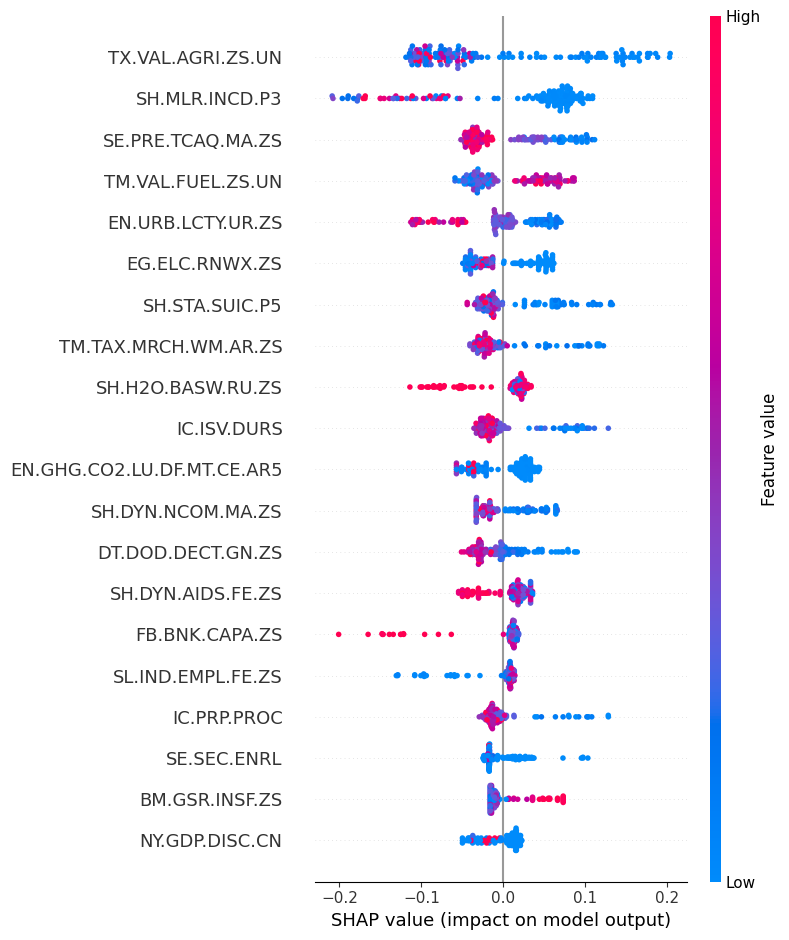

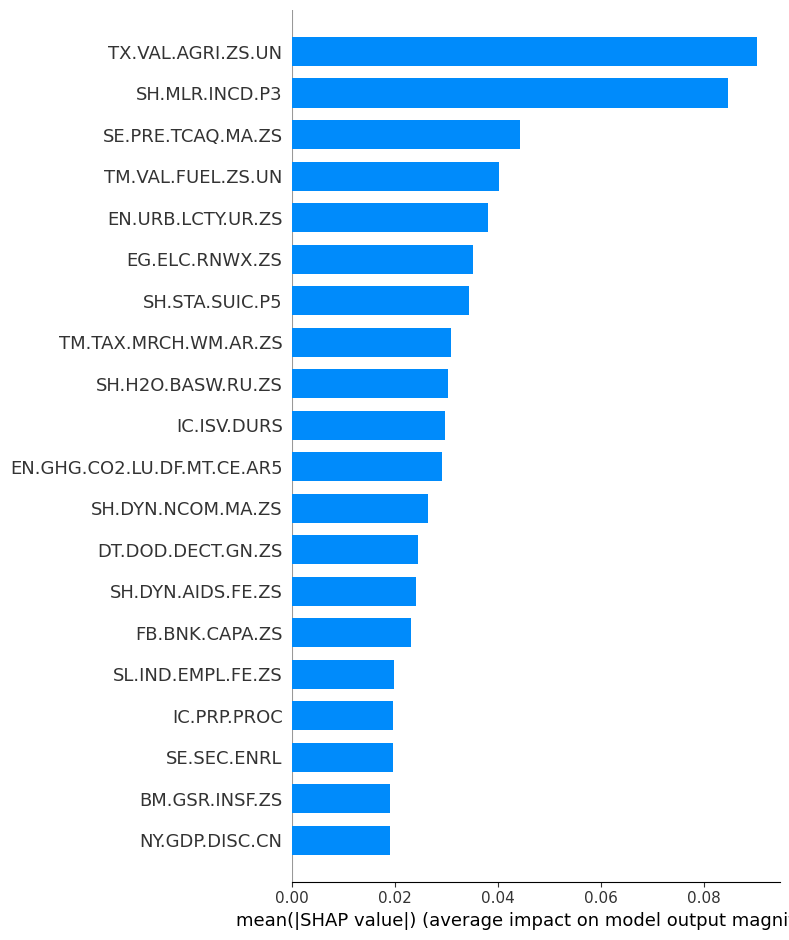

In [ ]:
# SHAP analysis
import shap
import matplotlib.pyplot as plt

# Get the underlying XGBoost model from the pipeline
xgb_model = best_model.named_steps['model']

# Apply the scaler to transform the data first
X_train_scaled = best_model.named_steps['scaler'].transform(X_train)
X_test_scaled = best_model.named_steps['scaler'].transform(X_test)

# Initialize SHAP explainer with the XGBoost model only
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values on the scaled data
shap_values = explainer.shap_values(X_test_scaled)

# Save SHAP values
shap_values_df = pd.DataFrame(shap_values, columns=feature_columns)
shap_values_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/shap_values_{FILE_SUFFIX}.csv', index=False)
print(f"\nSHAP values saved to {FEATURE_IMPORTANCE_DIR}/shap_values_{FILE_SUFFIX}.csv")

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_columns, show=False)
plt.tight_layout()
plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_summary_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
plt.show()

# Additionally, create a bar plot of SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_columns, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_importance_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
shap_pivot = shap_values_df.T.abs().sum(axis=1).sort_values(ascending=False)
shap_pivot_df = pd.DataFrame(shap_pivot, columns=['SHAP Value'])
shap_pivot_df.reset_index(inplace=True)
shap_pivot_df.columns = ['Feature', 'SHAP Value']

lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)

shap_pivot_df_merged = shap_pivot_df.merge(lookup, how='left', left_on='Feature', right_on='Indicator Code')

shap_pivot_df_merged = shap_pivot_df_merged[['Indicator Code', 'Indicator Name', 'Topic', 'SHAP Value']]

shap_pivot_df_merged.to_csv(f'{FEATURE_IMPORTANCE_DIR}/SHAP_top_features_{FILE_SUFFIX}.csv', index=False)

shap_pivot_df_merged

,Indicator Code,Indicator Name,Topic,SHAP Value
0,TX.VAL.AGRI.ZS.UN,Agricultural raw materials exports (% of merch...,Private Sector & Trade: Exports,13.527969
1,SH.MLR.INCD.P3,"Incidence of malaria (per 1,000 population at ...",Health: Risk factors,12.701502
2,SE.PRE.TCAQ.MA.ZS,"Trained teachers in preprimary education, male...",Education: Inputs,6.641916
3,TM.VAL.FUEL.ZS.UN,Fuel imports (% of merchandise imports),Private Sector & Trade: Imports,6.021479
4,EN.URB.LCTY.UR.ZS,Population in the largest city (% of urban pop...,Environment: Density & urbanization,5.707624
...,...,...,...,...
1167,NV.AGR.TOTL.KN,"Agriculture, forestry, and fishing, value adde...",Economic Policy & Debt: National accounts: Loc...,0.000000
1168,NV.AGR.TOTL.ZS,"Agriculture, forestry, and fishing, value adde...",Economic Policy & Debt: National accounts: Sha...,0.000000
1169,NV.IND.EMPL.KD,"Industry (including construction), value added...",Economic Policy & Debt: National accounts: US$...,0.000000
1170,NV.IND.MANF.CD,"Manufacturing, value added (current US$)",Economic Policy & Debt: National accounts: US$...,0.000000
